# <center>CNN Visualization and Style Transfer</center>
<center><br/>June 2017</center>


Today we are going to learn about how to visualize a neural network, and also introduce you to a very interesting work nick named as style transfer, which is to tranfer to style of one image to another image.



Here is the objective of this tutorial:

- [Visualize Convolutional Neural Networks](#visualizing-convolutional-neural-network)
    - [Visualizing Filters](#visualizing-filters)
    - [Visualizing Convolutional Output](#visualizing-convolutional-output)
    - [Visualizing Gradient](#visualizing-gradient)

- [A Neural Algorithm of Artistic Style](#a-neural-algorithm-of-artistic-style)
    - [Defining the Content Features and Style Features](#defining-the-content-features-and-style-features)
    - [Defining the Loss](#defining-the-loss)
    - [Art Gallery](#art-gallery)

<a name="deep-convolutional-networks"></a>
# Visualize Convolutional Neural Networks


Today, We are going to visualize a neural network pretrained by imagenet, a large dataset used in a challenge called the IamgeNet Large Scale Visual Recognition Challenge. The dataset contains nearly 1.2 million images composed of 1000 different types of objects, and the network learned how to create useful representation of the data to differentiate between difference class. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipyd
import scipy.misc
from libs import utils

Let's use wonder woman as a sample image to feed in the network today

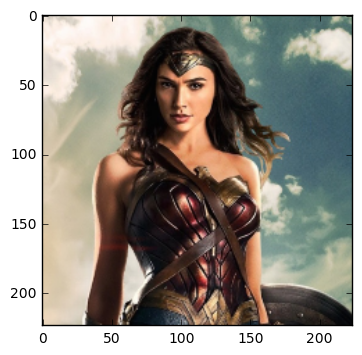

In [2]:
processed_img = utils.load_image('wonder-woman.jpg')
plt.imshow(processed_img)

Our images must be shaped as a 4-dimensional shape describing the number of images, height, width, and number of channels before being fed into the network.  So our original 3-dimensional image of height, width, channels needs an additional dimension on the 0th axis.

In [3]:
processed_img_4d = processed_img[np.newaxis]
print(processed_img_4d.shape)

(1, 224, 224, 3)


<a name="loading-a-pretrained-network"></a>
## Loading a Pretrained Network

please download [weight(vgg19.npy)](!https://mega.nz/#!xZ8glS6J!MAnE91ND_WyfZ_8mvkuSa2YcA7q-1ehfSm-Q1fxOvvs) and put it in the libs directory as this notebook

In [4]:
from libs import vgg19
sess = tf.InteractiveSession()
images = tf.placeholder(tf.float32, [1, 224, 224, 3])
train_mode = tf.placeholder(tf.bool)

vgg = vgg19.Vgg19()
vgg.build(images, train_mode)
sess.run(tf.global_variables_initializer())

In [5]:
softmax = vgg.prob
res = np.squeeze(softmax.eval(feed_dict={images: processed_img_4d, train_mode:False}))

The result of the network is a 1000 element vector, with probabilities of each class. We can sort these and use the labels of the 1000 classes to see what the top 5 predicted probabilities and labels are:

In [6]:
utils.print_prob(res)

('Top1: ', ['maillot'], 0.51197863)
('Top5: ', [(['maillot'], 0.51197863), (['bikini,', 'two-piece'], 0.1334984), (['miniskirt,', 'mini'], 0.12154517), (['maillot,', 'tank', 'suit'], 0.051042411), (['gown'], 0.029725766)])


<a name="visualizing-filters"></a>
## Visualizing Filters

Let's try to first visualize the weights of the convolution filters.

In [7]:
W_vgg = vgg.data_dict['conv1_1'][0]
print(W_vgg.shape)
# [filter_height, filter_width, in_channels, out_channels]

(3, 3, 3, 64)


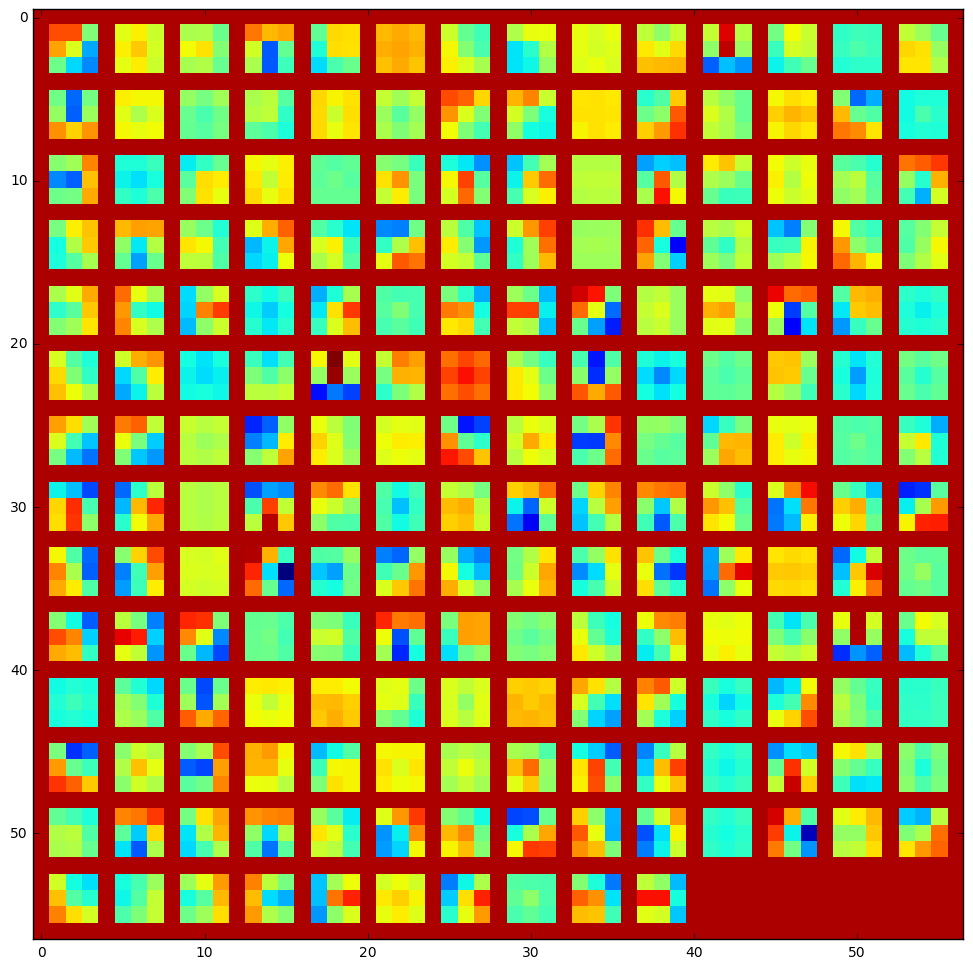

In [8]:
W_montage = utils.montage_filters(W_vgg[:10])
plt.figure(figsize=(12,12))
plt.imshow(W_montage, interpolation='nearest')

They are responding to edges, corners, and center-surround or some kind of contrast of two things, like red, green, blue yellow.

<a name='visualizing-convolutional-output'></a>
## Visualizing Convolutional Output

Also we can take a look at the convolutional output. We've just seen what each of the convolution filters look like.  Let's try to see how they filter the image now by looking at the resulting convolution.

In [9]:
vgg_conv1_1 = vgg.conv1_1.eval(feed_dict={images: processed_img_4d, train_mode:False}) 
vgg_conv2_1 = vgg.conv2_1.eval(feed_dict={images: processed_img_4d, train_mode:False})
vgg_conv5_1 = vgg.conv5_1.eval(feed_dict={images: processed_img_4d, train_mode:False})

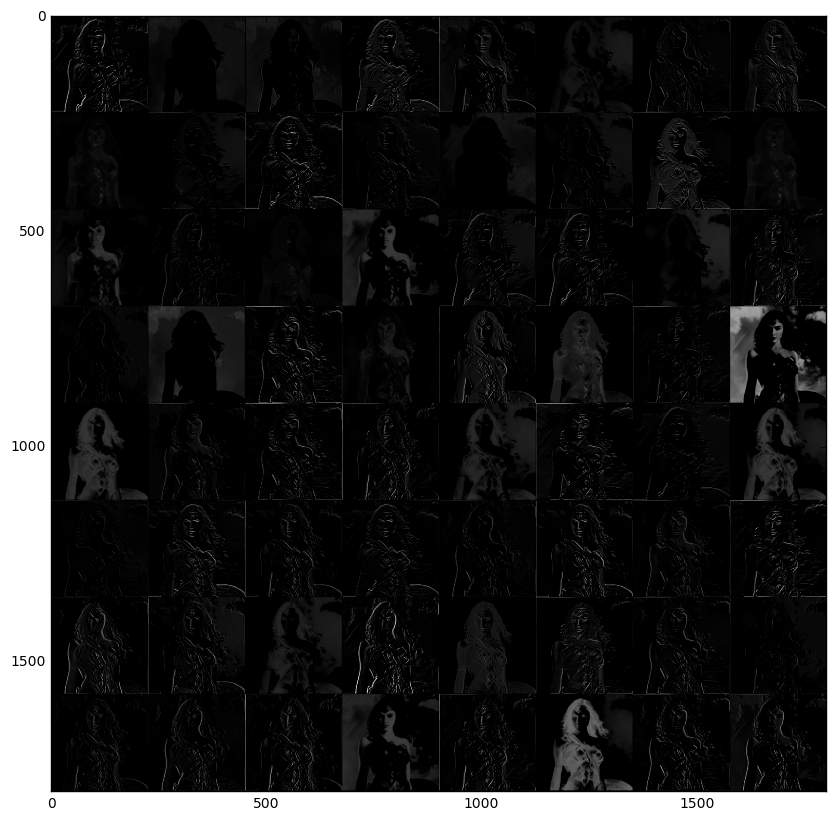

In [10]:
feature = vgg_conv1_1
montage = utils.montage_filters(np.rollaxis(np.expand_dims(feature[0], 3), 3, 2))
plt.figure(figsize=(10, 10))
plt.imshow(montage, cmap='gray')

And the convolutional from second block

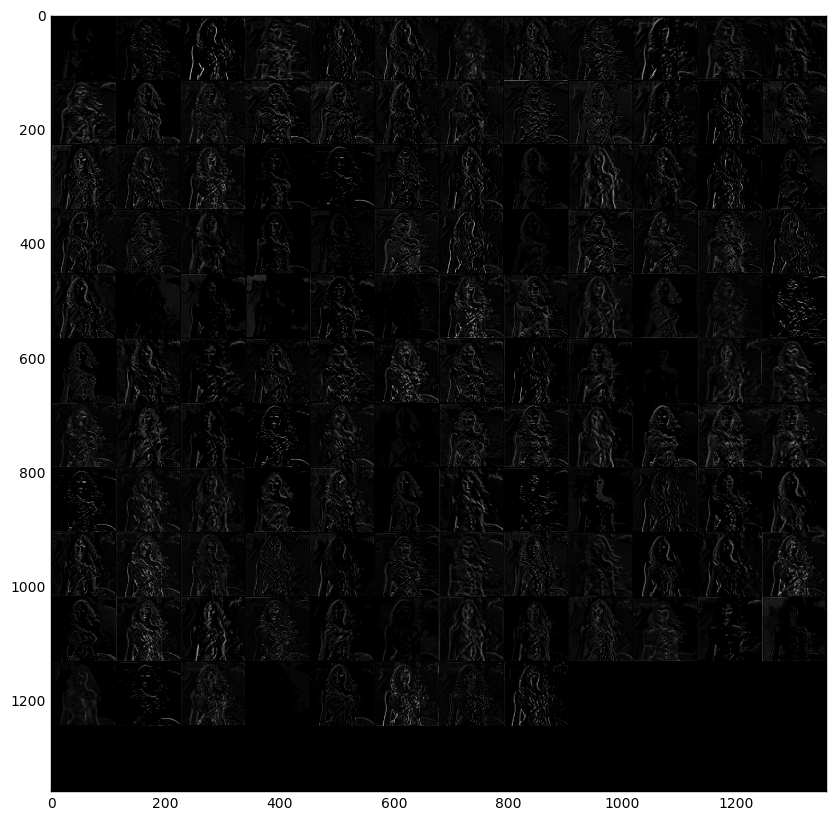

In [11]:
feature = vgg_conv2_1
montage = utils.montage_filters(np.rollaxis(np.expand_dims(feature[0], 3), 3, 2))
plt.figure(figsize=(10, 10))
plt.imshow(montage, cmap='gray')

Let's look at the shape of the convolutional output:

In [12]:
layer_shape = tf.shape(feature).eval(feed_dict={images:processed_img_4d, train_mode:False})
print(layer_shape)

[  1 112 112 128]


Our original image which was 1 x 224 x 224 x 3 color channels, now has 128 new channels of information. Some channels capture edges of the body, some capture the face. 

We can also try to visualize some features from higher levels.

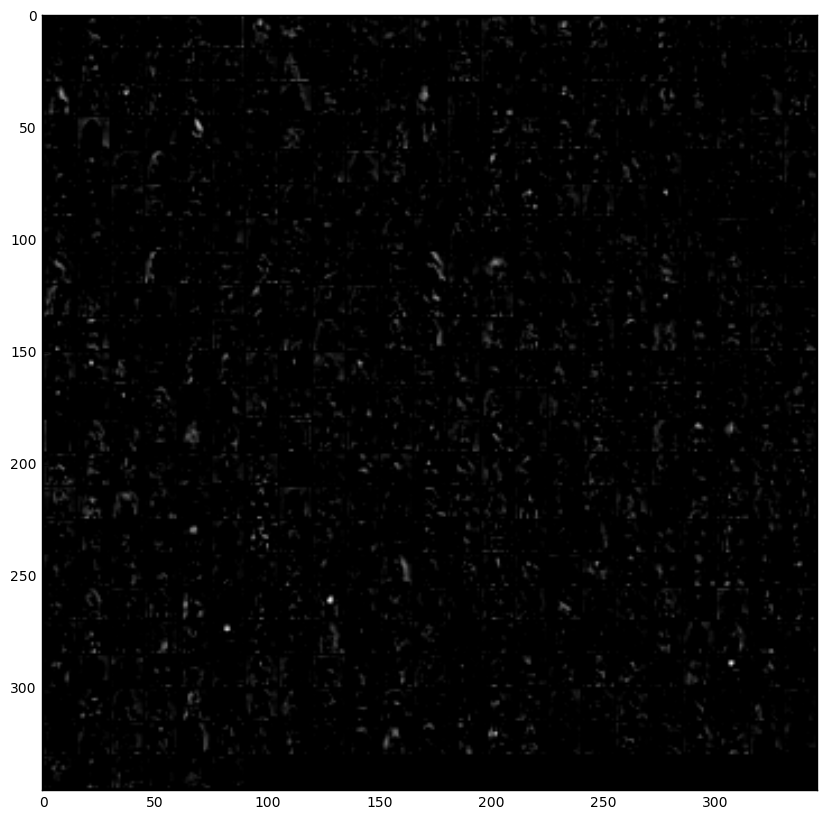

In [13]:
feature = vgg_conv5_1
montage = utils.montage_filters(np.rollaxis(np.expand_dims(feature[0], 3), 3, 2))
plt.figure(figsize=(10, 10))
plt.imshow(montage, cmap='gray')

It's more difficult to tell what's going on in this case.

<a name='visualizing-gradient' ></a>
## Visualizing Gradient  

Visualizing convolutional output is a pretty useful technique for the shallow convolution layers, but when we get to the deeper layers, we have many different channels of information being fed to deeper convolution filters of some very high dimensions.  It's hard to understand them just by plotting the convolution output.

If we want to understand what the deeper layers are really doing, we can try to use backprop to show us the gradients of a particular neuron with respect to our input image.  Let's visualize the network's gradient when backpropagated to the original input image.  
**This is telling us which pixels are responding to the predicted class or given neuron.**

We firstly forward pass up to the layer that we are interested in, and then backprop to help us understand what pixels in particular contributed to the final activation of that layer the most.  We first create an operation which will find the max neuron of all activations in a layer, and then calculate the gradient of that objective with respect to the input image.

In [22]:
feature = vgg.conv4_2
gradient = tf.gradients(tf.reduce_max(feature, axis=3), images)

When we run this network now, we will specify the gradient operation we've created, instead of the softmax layer of the network.  This will run a forward prop up to the layer we asked to find the gradient with, and then run a back prop all the way to the input image.

In [23]:
res = sess.run(gradient, feed_dict={images: processed_img_4d, train_mode:True})[0]

Let's visualize the original image and the output of the backpropagated gradient:

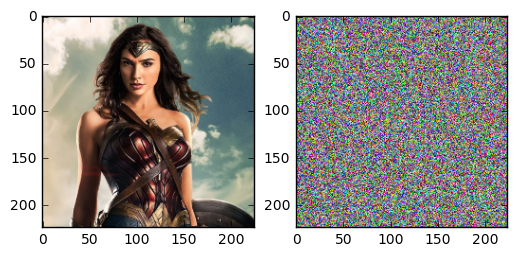

In [24]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(processed_img)
axs[1].imshow(res[0])

It's hard to understand the gradient this way. What we can do is normalize the gradient in a way that let us see it more in terms of the normal range of color values.

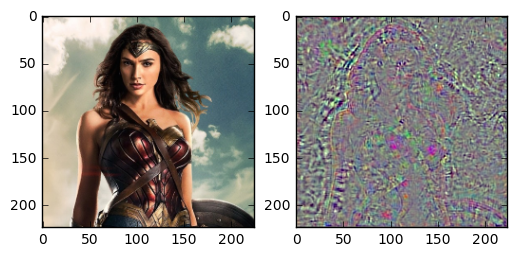

In [25]:
res_normalized = utils.normalize(res)
fig, axs = plt.subplots(1, 2)
plt.figure(figsize=(10,10))
axs[0].imshow(processed_img)
axs[1].imshow(res_normalized[0])

We can see that the edges of wonder woman triggers the neurons the most!

Let's create utility functions which will help us visualize any single neuron in a layer.

In [26]:
def compute_gradient_single_neuron(feature, neuron_i):
    '''visualize a single neuron in a layer, with neuron_i speicify the number of the neuron'''
    gradient = tf.gradients(tf.reduce_mean(feature[:, :, :, neuron_i]), images)
    res = sess.run(gradient, feed_dict={images: processed_img_4d, train_mode: False})[0]
    return res

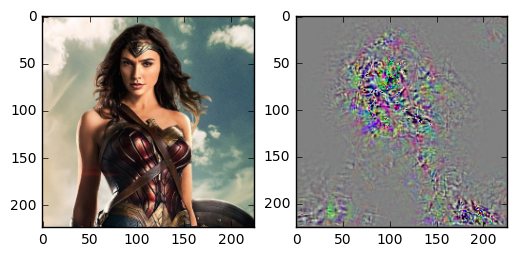

In [33]:
gradient = compute_gradient_single_neuron(vgg.conv5_2, 77)
gradient_norm = utils.normalize(gradient)
montage = utils.montage(np.array(gradient_norm))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(processed_img)
axs[1].imshow(montage)

seems like this neuron reacts to face and hair

<a name='a-neural-algorithm-of-artistic-style' ></a>
# A Neural Algorithm of Artistic Style
Visualizing neural network gives us a better understanding of exactly what's going in the mysterious huge network. Besides from this application, Leon Gatys and his co-authors has a very interesting work called "A Neural Algorithm of Artistic Style" that uses neural representations to separate and recombine content and style of arbitrary images, providing a neural algorithm for the creation of artistic images.

Turns out the correlations between the different filter responses is a representation of styles. Fascinating, right?

<a name='defining-the-content-features' ></a>
##  Defining the Content Features and Style Features
- Content features of the content image is calculated by feeding the content image into the neural network, and extract the activations of thoe CONTENT_LAYERS. 

- For style features, we extract the correlation of the features of the style-image layer-wise (the gram matrix). By adding up the feature correlations of multiple layers, we obtain a multi-scale representation of the input image, which captures its texture information instead of the object arrangement in the input image.

Given the content features and the stlye features, we can design a loss function that makes the final image contains the content but are illustrated in the style of the style-image.

<a name='defining-the-content-loss' ></a>
## Defining the Loss

Our goal is to create an output image which are synthesized by finding an image that simultaneously matches the content features of the photograph and the style features of the respective piece of art. How can we do that? 
We can define the loss function as the composition of
1. the dissimilarity of the content features between the output image and the content images
2. the dissimilarity of the style features between the output image and the style image
to the loss function.

The following figure gives a very good explanation.

<img src="fig-style-transfer-algorithm.png" width="800">

- $G^{l}_{ij}$ is the inner product between the vectorised feature maps of the initial image $i$ and $j$ in layer $l$,
- $w_{l}$ is the weight of each style layers
- $A^{l}$ is that of the style image
- $F^{l}$ is layer-wise content features of the initial image
- $P^{l}$ is that of the content image

We start by a noisy initial image, set it as tensorflow Variable, and instead of doing gradient descent on the weight, we fix the weight and do gradient descent on the initial image to minimize the lose function(which is a sum of style loss and content loss).

It might be easier for you to understand through code. Let's start by prepare our favorite content image and style image from some great artists. I will stick with wonder woman as an example because I am a big fan of her. For the style image I pick Van Goah's classic work starry night.

In [10]:
import os
content_directory = 'contents/'
style_directory = 'styles/'

# This is the directory to store the final stylized images
output_directory = 'image_output/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
# This is the directory to store the half-done images during the training.
checkpoint_directory = 'checkpoint_output/'
if not os.path.exists(checkpoint_directory):
    os.makedirs(checkpoint_directory)
    
content_path = os.path.join(content_directory, 'wonder-woman.jpg')
style_path = os.path.join(style_directory, 'starry-night.jpg')
output_path = os.path.join(output_directory, 'wonder-woman-starry-night-iteration-1000.jpg')
# please notice that the checkpoint_images_path has to contain %s in the file_name
checkpoint_path = os.path.join(checkpoint_directory, 'wonder-woman-starry-night-iteration-1000-%s.jpg')

In [11]:
content_image = utils.imread(content_path)
# You can pass several style images as a list, but let's use just one for now.
style_images = [utils.imread(style_path)]

Let's take a look at our content image and style image

<img src='contents/wonder-woman.jpg' width=800>
<img src='styles/starry-night.jpg' width=600>

# Utility functions for loading simply the convolution layers of the vgg19 model

In [39]:
import tensorflow as tf
import numpy as np
import scipy.io
import os
VGG_MEAN = [103.939, 116.779, 123.68]
VGG19_LAYERS = (
    'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

    'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

    'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
    'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

    'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
    'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

    'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
    'relu5_3', 'conv5_4', 'relu5_4'
)


def net_preloaded(input_image, pooling):
    data_dict = np.load('libs/vgg19.npy', encoding='latin1').item()
    net = {}
    current = input_image
    for i, name in enumerate(VGG19_LAYERS):
        kind = name[:4]
        if kind == 'conv':
            kernels = get_conv_filter(data_dict, name)
            # kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = get_bias(data_dict, name)
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]

            # bias = bias.reshape(-1)
            current = conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = pool_layer(current, pooling)
        net[name] = current

    assert len(net) == len(VGG19_LAYERS)
    return net

def conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, weights, strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)


def pool_layer(input, pooling):
    if pooling == 'avg':
        return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                padding='SAME')
    else:
        return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                padding='SAME')
# before we feed the image into the network, we preporcess it by extracting the mean_pixel from it.
def preprocess(image):
    return image - VGG_MEAN

# rememeber to unprocess it before you plot it out and save it.
def unprocess(image):
    return image + VGG_MEAN

def get_conv_filter(data_dict, name):
    return tf.constant(data_dict[name][0], name="filter")

def get_bias(data_dict, name):
    return tf.constant(data_dict[name][1], name="biases")


# The Algorithm
This is the main algorithm we will be using to stylize the network. There are a lot of hyper-parameters you can tune. the output image will be store at `output_path`, and the checkpoint image(stylized images on every `checkpoint_iterations` steps) will be store at `checkpoint_path` if specified.

In [40]:
import tensorflow as tf
import numpy as np
from functools import reduce
from PIL import Image
# feel free to try different layers
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
# CONTENT_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')
VGG_MEAN = [103.939, 116.779, 123.68]

def stylize(content, styles, network_path='libs/imagenet-vgg-verydeep-19.mat', iterations=1000,
        content_weight=5e0, content_weight_blend=0.5, style_weight=5e2, style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=None, output_path=None):
    
    # calculate the shape of the network input tensor according to the content image
    shape = (1,) + content.shape
    style_shapes = [(1,) + style.shape for style in styles]
    content_features = {}
    style_features = [{} for _ in styles]

    # scale the importance of each sytle layers according to their depth. (deeper layers are more important if style_layers_weights > 1 (default = 1))
    layer_weight = 1.0
    style_layers_weights = {}
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] = layer_weight
        layer_weight *= style_layer_weight_exp

    # normalize style layer weights
    layer_weights_sum = 0
    for style_layer in STYLE_LAYERS:
        layer_weights_sum += style_layers_weights[style_layer]
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] /= layer_weights_sum

    # compute content features of the content image by feeding it into the network
    g = tf.Graph()
    with g.as_default(), tf.Session() as sess:
        image = tf.placeholder('float', shape=shape)
        # net = net_preloaded(vgg_weights, image, pooling)
        net = net_preloaded(image, pooling)
        content_pre = np.array([preprocess(content)])
        for layer in CONTENT_LAYERS:
            content_features[layer] = net[layer].eval(feed_dict={image: content_pre})

    # compute style features of the content image by feeding it into the network, and calculate the gram matrix
    for i in range(len(styles)):
        g = tf.Graph()
        with g.as_default(), tf.Session() as sess:
            image = tf.placeholder('float', shape=style_shapes[i])
            net = net_preloaded(image, pooling)
            style_pre = np.array([preprocess(styles[i])])
            for layer in STYLE_LAYERS:
                features = net[layer].eval(feed_dict={image: style_pre})
                features = np.reshape(features, (-1, features.shape[3]))
                gram = np.matmul(features.T, features) / features.size
                style_features[i][layer] = gram

    # make stylized image using backpropogation
    
    with tf.Graph().as_default():

        initial = tf.random_normal(shape) * 0.256

        image = tf.Variable(initial)

        net = net_preloaded(image, pooling)
        # content loss, we can adjust the weight of each content layers
        content_layers_weights = {}
        content_layers_weights['relu4_2'] = content_weight_blend
        content_layers_weights['relu5_2'] = 1.0 - content_weight_blend      
        
        content_loss = 0
        content_losses = []
        for content_layer in CONTENT_LAYERS:
            content_losses.append(content_layers_weights[content_layer] * content_weight * (2 * tf.nn.l2_loss(
                    net[content_layer] - content_features[content_layer]) /
                    content_features[content_layer].size))
        content_loss += reduce(tf.add, content_losses)

        # We can specify different weight for different style images, be default is the same for all stlye_images
        if style_blend_weights is None:
            style_blend_weights = [1.0/len(style_images) for _ in style_images]
        else:
            total_blend_weight = sum(style_blend_weights)
            # normalization
            style_blend_weights = [weight/total_blend_weight
                                   for weight in style_blend_weights]
        # style loss
        style_loss = 0
        # iterate to calculate style lose with multiple style images
        for i in range(len(styles)):
            style_losses = []
            for style_layer in STYLE_LAYERS:
                layer = net[style_layer]
                _, height, width, number = map(lambda i: i.value, layer.get_shape())
                size = height * width * number
                feats = tf.reshape(layer, (-1, number))
                gram = tf.matmul(tf.transpose(feats), feats) / size
                style_gram = style_features[i][style_layer]
                style_losses.append(style_layers_weights[style_layer] * 2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
            style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)


        # total variation denoising to do smoothing, according to the paper
        # Mahendran, Aravindh, and Andrea Vedaldi. "Understanding deep image representations by inverting them."
        # Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.
        tv_y_size = _tensor_size(image[:,1:,:,:])
        tv_x_size = _tensor_size(image[:,:,1:,:])
        tv_loss = tv_weight * 2 * (
                (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
                    tv_y_size) +
                (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
                    tv_x_size))

        # overall loss
        loss = content_loss + style_loss + tv_loss

        train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

        def print_progress():
            print('     iteration: %d\n' % i)
            print('  content loss: %g\n' % content_loss.eval())
            print('    style loss: %g\n' % style_loss.eval())
            print('       tv loss: %g\n' % tv_loss.eval())
            print('    total loss: %g\n' % loss.eval())
            
        def imsave(path, img):
            img = np.clip(img, 0, 255).astype(np.uint8)
            Image.fromarray(img).save(path, quality=95)

        # optimization
        best_loss = float('inf')
        best = None
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            if (print_iterations and print_iterations != 0):
                print_progress()
            for i in range(iterations):
                # print('Iteration %4d/%4d\n' % (i + 1, iterations))
                train_step.run()

                last_step = (i == iterations - 1)
                if last_step or (print_iterations and i % print_iterations == 0):
                    print_progress()
                
                # store output and checkpoint images
                if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
                    this_loss = loss.eval()
                    if this_loss < best_loss:
                        best_loss = this_loss
                        best = image.eval()

                    #img_out = unprocess(best.reshape(shape[1:]), vgg_mean_pixel)
                    img_out = unprocess(best.reshape(shape[1:]))
                    
                    output_file = None
                    if not last_step:
                        if checkpoint_path:
                            output_file = checkpoint_path % i
                    else:
                        output_file = output_path
                    if output_file:
                        imsave(output_file, img_out)

    print("finish stylizing.")
def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

It might takes a while according to your machine to run it, please be patient.

In [43]:
stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, style_layer_weight_exp=1, style_blend_weights=None, tv_weight=0,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path, output_path=output_path)

     iteration: 0

  content loss: 383746

    style loss: 1.51641e+06

       tv loss: 0

    total loss: 1.90016e+06

     iteration: 0

  content loss: 365699

    style loss: 1.27573e+06

       tv loss: 0

    total loss: 1.64143e+06

     iteration: 100

  content loss: 84582.9

    style loss: 22736.3

       tv loss: 0

    total loss: 107319

     iteration: 200

  content loss: 73434.2

    style loss: 21405.8

       tv loss: 0

    total loss: 94840

     iteration: 300

  content loss: 70032.9

    style loss: 23293.1

       tv loss: 0

    total loss: 93326

     iteration: 400

  content loss: 71076.1

    style loss: 22522.8

       tv loss: 0

    total loss: 93599

     iteration: 500

  content loss: 71802.9

    style loss: 23783.6

       tv loss: 0

    total loss: 95586.5

     iteration: 600

  content loss: 69266

    style loss: 22475

       tv loss: 0

    total loss: 91741

     iteration: 700

  content loss: 69589.5

    style loss: 22351.1

       tv lo

<img src="image_output/wonder-woman-starry-night-tv-weight-100.jpg" width="800">


Not bad! 

If you notice, besides from style loss and content lose, I add an total variational loss(`tv_loss`) to denoise. Here is an example without total variation loss.

<img src="image_output/wonder-woman-starry-night-tv-weight-0.jpg" width="800">

We can see there are more jiggling spots in the figure above.

<a name='art-gallery' ></a>
## Art Gallery

I also try to combine wonder woman with "rain-princess" by Leonid Afremov

<img src='styles/rain-princess.jpg' width='600'>
<img src='image_output/wonder-woman-rain-princess-style-weight-2000-pooling-avg.jpg' width='800'>


"scream" by Edvard Munch

<img src='styles/the-scream.jpg' width='600'>
<img src='image_output/wonder-woman-the-scream-style-weight-1500-pooling-avg.jpg' width='800'>

and mix two style(starry night and rainy night) together!

<img src='image_output/wonder-woman-starry-night-rain-princess-style-weight-2000-pooling-avg.jpg' width=800>

According to the original style transfer paper, replacing the maximum pooling operation by average pooling yields slightly more appealing results. So I use average pooling as the default pooling operation. Here is a experiment using max(upper image) v.s. average(lower image) as the pooling operation. (style: rain princess)

<img src='image_output/wonder-woman-rain-princess-style-weight-2000-pooling-max.jpg' width=800>
<img src='image_output/wonder-woman-rain-princess-style-weight-2000-pooling-avg.jpg' width=800>

There are a lot of different things you can playaround with this style trasnfer algorithm. Feel free to add your own thoughts in it!